In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


In [2]:
!pip install -q kaggle
import json

data = {"username":"tunkedsaro","key":"ff3d00dc680ff94caf6f8d4d9bcd3168"}
json_data = json.dumps(data)

# Write the JSON string to a file
file_path = "/content/kaggle.json"
with open(file_path, 'w') as json_file:
    json_file.write(json_data)

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/ #copy api key ---- depend on your directory -- my directory is .../colab/..
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle competitions download -c forest-type-classification-spai

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
shreyanshverma27/online-sales-dataset-popular-marketplace-data  Online Sales Dataset - Popular Marketplace Data      7KB  2024-05-25 23:55:26           3248         62  1.0              
devarajv88/walmart-sales-dataset                                e-Commerce (Walmart) Sales Dataset                   5MB  2024-05-30 12:09:55           2051         34  1.0              
ayushparwal2026/country-population-from-1960-to-2022            Country Population from 1960 to 2022                75KB  2024-05-31 08:58:26           1538         39  0.9411765        
mayankanand2701/apple-stock-price-dataset                       A

In [3]:
!unzip /content/forest-type-classification-spai.zip

Archive:  /content/forest-type-classification-spai.zip
  inflating: metaData.csv            
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [18]:
import optuna
import pandas as pd
import lightgbm as lgb
import time
from sklearn.model_selection import cross_val_score
import numpy as np

In [ ]:
a = a.rename(columns={
    'BVP':'BVPstd',
    'ACC_X':'ACC_Xstd',
    'ACC_Y':'ACC_Ystd',
    'ACC_Z':'ACC_Zstd',
    'TEMP':'TEMPstd',
    'EDA':'EDAstd',
    'HR':'HRstd',
    'IBI':'IBIstd'
})
a

In [19]:
# test.csv
train_df = pd.read_csv("/content/train.csv")
# train_df = train_df[0:10]
# train_df
train_df = train_df.rename(columns = {
    'b1':'01Coastal',
    'b2':'02Blue',
    'b3':'03Green',
    'b4':'04Red',
    'b5':'05Veg5',
    'b6':'06Veg6',
    'b7':'07Veg7',
    'b8':'08NIR',
    'b8_a':'09NIRn',
    'b9':'10WV',
    'b10':'11SWIR-C',
    'b11':'12SWIR1',
    'b12':'13SWIR2'
})

# 0:15 /
train_df['ATSAVI'] = (train_df['09NIRn'] - (0.33 * train_df['04Red']) - (0.5 * train_df['08NIR'] + train_df['04Red'] - (0.5 * 0.33)) + (1 + (0.33 ** 2)))
train_df['AFRI1600'] = (train_df['08NIR'] - 0.6616*train_df['08NIR'] + 0.6616*train_df['08NIR'])
train_df['AFRI2100'] = (train_df['08NIR'] - 0.521 * train_df['08NIR'] + 0.562 * train_df['08NIR'])
train_df['ARI'] = (train_df['12SWIR1'] - train_df['13SWIR2']) / (train_df['12SWIR1'] + train_df['13SWIR2'])
train_df['ARVI'] = (train_df['08NIR'] - train_df['04Red'] - (train_df['08NIR'] - train_df['02Blue']))/(train_df['08NIR'] + train_df['04Red'] - (train_df['08NIR'] - train_df['02Blue']))
train_df['ARVI2'] = -0.18+1.17*((train_df['08NIR']-train_df['04Red'])/(train_df['08NIR']+train_df['04Red']))
train_df['BWDRVI'] = (train_df['08NIR'] - train_df['02Blue']) / (train_df['08NIR'] + train_df['02Blue'])
train_df['BRI'] = train_df['12SWIR1'] - train_df['13SWIR2']
train_df['CCCI'] = (train_df['08NIR'] - train_df['07Veg7']) / (train_df['08NIR'] + train_df['07Veg7'] - train_df['04Red'] + train_df['04Red'])
train_df['CARI2'] = (((np.abs(train_df['08NIR'] - train_df['06Veg6']) + np.abs(train_df['08NIR'] + train_df['06Veg6'])) ** 0.5) * train_df['07Veg7'])
train_df['Chlgreen'] = (train_df['07Veg7'] - train_df['03Green']) * (-1)
train_df['CIgreen'] = train_df['08NIR'] - train_df['03Green']
train_df['CIrededge'] = train_df['09NIRn'] - 1
train_df['ChlRed-Edge'] = (train_df['08NIR'] - train_df['07Veg7']) * -1
train_df['CI'] = train_df['04Red'] - train_df['02Blue']
# 16:30
train_df['CRI700'] = (-1) * train_df['01Coastal'] + (-1) * train_df['03Green']
train_df['GDVI'] = train_df['08NIR'] - train_df['03Green']
train_df['EVI'] = 2.5 * train_df['08NIR'] - train_df['04Red'] * (train_df['08NIR'] + 6 * train_df['04Red'] - 7.5 * train_df['02Blue'] + 1)
train_df['EVI2'] = 2.4 * train_df['08NIR'] - train_df['04Red'] / (train_df['08NIR'] + train_df['04Red'] + 1)
train_df['EVI2'] = 2.5 * train_df['08NIR'] - train_df['04Red'] * train_df['08NIR'] + 2.4 *  train_df['04Red'] + 1
train_df['EPI'] = (train_df['05Veg5'] * train_df['02Blue'] * train_df['03Green'])
train_df['GEMI'] = (train_df['08NIR'] - (0.25 * train_df['08NIR'])) - (train_df['04Red'] + (0.125 * train_df['04Red']))
train_df['GVMI'] = (train_df['08NIR'] + 0.1) - (train_df['12SWIR1'] + 0.02) / (train_df['08NIR'] + 0.1) + (train_df['12SWIR1'] + 0.02)
train_df['GARI'] = (train_df['08NIR'] - (train_df['03Green'] - (train_df['02Blue'] - train_df['04Red']))) / (train_df['08NIR'] + (train_df['03Green'] + (train_df['02Blue'] - train_df['04Red'])))
train_df['GLI'] = 2 * train_df['03Green'] - train_df['04Red'] - train_df['02Blue'] / (2 * train_df['03Green'] + train_df['04Red'] + train_df['02Blue'])
train_df['GNDVI'] = train_df['08NIR'] - train_df['03Green'] / (train_df['08NIR'] + train_df['03Green'])
train_df['GOSAVI'] = train_df['08NIR'] - train_df['09NIRn'] + train_df['03Green'] + train_df['04Red']
train_df['GSAVI'] = train_df['08NIR'] - train_df['09NIRn'] + train_df['03Green'] + (0.5 * (1 + 0.5))
# 31:45
train_df['IVI'] = train_df['08NIR'] - train_df['04Red'] * 2
train_df['NDVI'] = (train_df['08NIR'] - train_df['04Red']) / (train_df['08NIR'] + train_df['04Red'])
train_df['IPVI'] = 1/(train_df['08NIR']/train_df['10WV'] + (train_df['04Red']/train_df['10WV'])**2) * (train_df['NDVI'] + 1)
train_df['IR700'] = 1/(train_df['07Veg7']+1e-8)
train_df['LCI'] = (train_df['01Coastal'] - train_df['06Veg6']) / (train_df['01Coastal'] + train_df['06Veg6'])
train_df['LogR'] = np.log(train_df['08NIR'] / train_df['04Red'])
train_df['MCARI/OSAVI'] = (
    (train_df['09NIRn'] - train_df['07Veg7'])
    + (-0.2 * (train_df['09NIRn'] - train_df['05Veg5']))
    * ((train_df['09NIRn'] - train_df['07Veg7'])
       * (1 + 0.16))
    / (train_df['08NIR'] - train_df['07Veg7'])
    + (train_df['08NIR'] + train_df['07Veg7']) + 0.16
)
train_df['mCRIRE'] = (-(train_df['03Green'] - train_df['06Veg6'])+train_df['08NIR'])
train_df['MVI'] = (train_df['12SWIR1'] + train_df['13SWIR2']) / 2
train_df['MCARI1'] = 1.2 * (2.5 * (train_df['08NIR'] - train_df['06Veg6']) - 1.3 * (train_df['08NIR'] - train_df['03Green']))
train_df['mNDVI'] = (train_df['08NIR'] - train_df['06Veg6']) / (train_df['08NIR'] + train_df['06Veg6'] - train_df['10WV'])
# 46:60
train_df['MSR670'] = ((train_df['08NIR'] - train_df['06Veg6']) / (train_df['08NIR'] + train_df['06Veg6']))**0.5
train_df['MSAVIhyper'] = (0.5)*((train_df['10WV']+1) - np.sqrt((train_df['10WV']+1)**2 - 8*(train_df['08NIR'] - train_df['05Veg5'])))
train_df['MTVI1'] = 1.2 * (1.2 * (train_df['08NIR'] - train_df['03Green']) - 2.5 * (train_df['06Veg6'] - train_df['03Green']))
train_df['MTVI2'] = (
    1.5 * (train_df['08NIR'] - train_df['05Veg5'])
    - 2.5 * (train_df['06Veg6'] - train_df['05Veg5'])
    * ((train_df['08NIR'] + 1) ** 2 - (train_df['06Veg6'] - 5 * train_df['06Veg6'] ** 0.5)) ** -0.5
)
train_df['NLI'] = train_df['02Blue'] ** 2 - train_df['04Red'] ** 2 + train_df['04Red']
train_df['Norm NIR'] = train_df['08NIR'] / (train_df['08NIR'] + train_df['03Green'] + train_df['04Red'])
train_df['Norm R'] = train_df['08NIR'] + train_df['04Red'] + train_df['03Green']
train_df['PPR'] = (train_df['05Veg5'] - train_df['04Red']) / (train_df['05Veg5'] + train_df['04Red'])
train_df['PVR'] = (train_df['02Blue'] - train_df['04Red']) / (train_df['02Blue'] + train_df['04Red'])
train_df['ND774/677'] = (train_df['06Veg6'] - train_df['05Veg5']) / (train_df['06Veg6'] + train_df['05Veg5'])
train_df['ND782/666'] = (train_df['07Veg7'] - train_df['06Veg6']) / (train_df['07Veg7'] + train_df['06Veg6'])
train_df['ND790/670'] = (train_df['05Veg5'] - train_df['03Green']) / (train_df['05Veg5'] + train_df['03Green'])
train_df['ND800/2170'] = (train_df['13SWIR2'] - train_df['04Red']) / (train_df['13SWIR2'] + train_df['04Red'])
# 61:75
train_df['PSNDc1'] = (train_df['08NIR'] - train_df['02Blue']) / (train_df['08NIR'] + train_df['02Blue'])
train_df['PSNDb1'] = (train_df['08NIR'] - train_df['01Coastal']) / (train_df['08NIR'] + train_df['01Coastal'])
train_df['PSNDa1'] = (train_df['08NIR']- train_df['02Blue'])/(train_df['08NIR']+train_df['02Blue'])
train_df['ND800/680'] = (train_df['08NIR'] - train_df['07Veg7']) / (train_df['08NIR'] + train_df['07Veg7'])
train_df['NDII'] = (train_df['12SWIR1'] - train_df['10WV']) / (train_df['12SWIR1'] + train_df['10WV'])
train_df['NDII2'] = (train_df['13SWIR2']-train_df['01Coastal'])/(train_df['13SWIR2']+train_df['01Coastal'])
train_df['ND833/658'] = (train_df['13SWIR2'] - train_df['12SWIR1']) / (train_df['13SWIR2'] + train_df['12SWIR1'])
train_df['SIWSI'] = (train_df['01Coastal'] - train_df['10WV']) / (train_df['01Coastal'] + train_df['10WV'])
train_df['ND895/675'] = (train_df['02Blue'] - train_df['03Green']) / (train_df['02Blue'] + train_df['03Green'])
train_df['NDVI_M'] = (train_df['13SWIR2'] - train_df['08NIR']) / (train_df['13SWIR2'] + train_df['08NIR'])
train_df['BNDVI'] = (train_df['08NIR'] - train_df['02Blue']) / (train_df['08NIR'] + train_df['02Blue'])
train_df['GNDVI'] = (train_df['08NIR'] - train_df['03Green']) / (train_df['08NIR'] + train_df['03Green'])
# 76:90
train_df['CDVI'] = (train_df['08NIR'] - train_df['04Red']) / (train_df['08NIR'] + train_df['04Red'])
train_df['NBR'] = (train_df['08NIR'] - train_df['12SWIR1']) / (train_df['08NIR'] + train_df['12SWIR1'])
train_df['RI'] = train_df['04Red'] - train_df['03Green'] + train_df['03Green']
train_df['NDVI690-710'] = train_df['08NIR'] / (train_df['08NIR'] + train_df['07Veg7'])
train_df['NDVIc'] = (train_df['08NIR'] - train_df['04Red']) / (train_df['08NIR'] + train_df['04Red']) * (1 - (train_df['12SWIR1'] - train_df['13SWIR2']) / (train_df['12SWIR1'] - train_df['13SWIR2'].min()) / (train_df['12SWIR1'] - train_df['13SWIR2'].min()))
train_df['PNDVI'] = (train_df['08NIR'] - (train_df['03Green'] + train_df['04Red'] + train_df['02Blue'])) / (train_df['08NIR'] + (train_df['03Green'] + train_df['04Red'] + train_df['02Blue']))
train_df['PVI'] = (1/(train_df['08NIR']**2 + 1)) * (train_df['08NIR'] - train_df['04Red'] - train_df['02Blue'])
train_df['RARSa1'] = train_df['02Blue'] / train_df['03Green']
train_df['RARSa2'] = (train_df['06Veg6'] - train_df['02Blue']) / (train_df['06Veg6'] + train_df['02Blue'])
train_df['RARSa3'] = train_df['05Veg5'] / train_df['06Veg6']
train_df['RARSc3'] = train_df['08NIR'] / train_df['04Red'] * 800 / 500
train_df['RARSc4'] = train_df['08NIR'] * train_df['03Green'] / (train_df['08NIR'] + train_df['03Green'])
train_df['RDVI'] = ((train_df['08NIR'] - train_df['06Veg6']) / (train_df['08NIR'] + train_df['06Veg6']))**0.5
# 91:105
train_df['Rededge1'] = (train_df['05Veg5'] - train_df['04Red']) / (train_df['05Veg5'] + train_df['04Red'])
train_df['RBNDVI'] = (train_df['08NIR'] - (train_df['04Red'] + train_df['02Blue'])) / (train_df['08NIR'] + (train_df['04Red'] + train_df['02Blue']))
train_df['REIP1'] = 700 + 40 * ((train_df['06Veg6'] + train_df['07Veg7']) / 2 - (train_df['05Veg5'] * train_df['08NIR']) / (train_df['05Veg5'] - train_df['08NIR']))
train_df['REIP2'] = 702 + 40 * ((train_df['07Veg7'] + train_df['08NIR']) ** 2 - train_df['07Veg7'] * train_df['08NIR'] - train_df['07Veg7'])
train_df['REIP3'] = 705 + 35 * ((train_df['05Veg5'] + train_df['07Veg7'] ** 2) - train_df['05Veg5'] * train_df['06Veg6'] - train_df['05Veg5'])
train_df['REP'] = 700 + 40 * ((train_df['07Veg7'] + train_df['10WV'] * 2) - (train_df['01Coastal'] + train_df['08NIR'] * 2))
train_df['Rre'] = np.sqrt(train_df['01Coastal'] + (train_df['03Green']**2))
train_df['RDVI'] = (train_df['08NIR'] - train_df['05Veg5']) / (train_df['08NIR'] + train_df['05Veg5'])**(1/2)
train_df['SAVImir'] = (train_df['08NIR']-train_df['12SWIR1']) + (train_df['08NIR'] + train_df['12SWIR1'] + 1) ** 0.5
train_df['MSI2'] = train_df['12SWIR1'] / train_df['03Green']
train_df['SR16502218'] = train_df['08NIR'] / train_df['09NIRn']
train_df['SR440/740'] = train_df['02Blue'] / train_df['06Veg6']
train_df['BGI'] = (train_df['02Blue'] / train_df['03Green'])
# 106:120
train_df['SR550/670'] = train_df['03Green'] / train_df['06Veg6']
train_df['SR550/800'] = train_df['03Green'] / train_df['10WV']
train_df['GI'] = train_df['03Green'] / train_df['06Veg6']
train_df['560/658'] = train_df['03Green'] / train_df['04Red']
train_df['SR672/550'] = train_df['06Veg6'] / train_df['02Blue']
train_df['SR 672/708'] = train_df['06Veg6'] / train_df['07Veg7']
train_df['SR675/555'] = train_df['06Veg6'] / train_df['03Green']
train_df['SR675/700'] = train_df['06Veg6'] / train_df['07Veg7']
train_df['SR675/705'] = train_df['04Red'] / train_df['03Green']
train_df['SR700'] = train_df['07Veg7']
train_df['SR700_670'] = train_df['03Green'] / train_df['02Blue']
train_df['SR735/710'] = train_df['03Green'] / train_df['02Blue']
train_df['SR774/677'] = train_df['08NIR'] / train_df['03Green']
train_df['800/2170'] = train_df['02Blue'] / train_df['09NIRn']
# 121:135
train_df['PSSRc1'] = train_df['08NIR'] / train_df['03Green']
train_df['PSSRb1'] = train_df['08NIR'] / train_df['04Red']
train_df['RVI'] = train_df['03Green'] / train_df['02Blue']
train_df['PSSRa1'] = train_df['12SWIR1'] / train_df['07Veg7']
train_df['SR800/680'] = train_df['08NIR'] / train_df['06Veg6']
train_df['SR801/550'] = train_df['08NIR'] / train_df['03Green']
train_df['PBI'] = train_df['12SWIR1'] / train_df['05Veg5']
train_df['SR833_1649'] = train_df['03Green'] / train_df['10WV']
train_df['SR833/658'] = train_df['07Veg7'] / train_df['06Veg6']
train_df['Datt2'] = train_df['07Veg7'] / train_df['06Veg6']
train_df['SR860/550'] = train_df['08NIR'] / train_df['03Green']
train_df['RDI'] = train_df['09NIRn'] / train_df['08NIR']
train_df['SRMIR/Red'] = train_df['13SWIR2'] / train_df['04Red']
train_df['SRnir/700-715'] = train_df['08NIR']
# 136:150
train_df['SRNIR/MIR'] = train_df['08NIR'] / train_df['09NIRn']
train_df['RRI1'] = train_df['08NIR'] / train_df['04Red']
train_df['SRRedNIR'] = train_df['04Red'] / train_df['08NIR']
train_df['SRSWIRI/NIR'] = train_df['12SWIR1'] / train_df['08NIR']
train_df['SB885'] = train_df['06Veg6']
train_df['SAVI'] = ((train_df['08NIR'] - train_df['04Red']) * (1 + 0.5)) / (train_df['08NIR'] + train_df['04Red'] + 0.5)
train_df['SARVI'] = (1 + 0.5) * train_df['08NIR'] - (0.2 * (train_df['04Red'] - train_df['03Green'])) + (0.1 * (train_df['04Red'] - train_df['03Green'])) + (0.5)
train_df['SARVI2'] = 2.5*train_df['08NIR'] - train_df['04Red'] + train_df['08NIR'] + 6*train_df['04Red'] - 7.5*train_df['02Blue']
train_df['SAVI3'] = (1 + 0.5) * (train_df['08NIR'] - train_df['04Red']) / (train_df['08NIR'] + train_df['04Red'] + 0.5)
train_df['SAVI2'] = ((train_df['08NIR'] - train_df['04Red']) * (1 + 0.5)) / (train_df['08NIR'] + train_df['04Red'] + 0.5)
train_df['SLAVI'] = train_df['08NIR'] + train_df['04Red'] + train_df['13SWIR2']
train_df['SQRT_IR/R'] = np.sqrt(train_df['08NIR'] / train_df['04Red'])
train_df['SIPI1'] = (train_df['04Red'] - train_df['03Green']) / (train_df['04Red'] - train_df['06Veg6'])
train_df['SBI'] = 0.3037 * train_df['03Green'] + 0.2793 * train_df['04Red'] + 0.4743 * train_df['07Veg7'] + 0.5585 * train_df['09NIRn'] + 0.5082 * train_df['10WV'] + 0.1863 * train_df['06Veg6']
# 151:165
train_df['NSIMSS'] = (-0.016 * train_df['05Veg5'] + 0.131 * train_df['06Veg6'] - 0.425 * train_df['07Veg7'] + 0.882 * train_df['09NIRn'])
train_df['SBIMSS'] = 0.332 * train_df['03Green'] + 0.603 * train_df['04Red'] + 0.675 * train_df['07Veg7'] + 0.262 * train_df['09NIRn']
train_df['GVI'] = -0.2848 * train_df['01Coastal'] - 0.2435 * train_df['02Blue'] - 0.5436 * train_df['06Veg6'] + 0.7243 * train_df['08NIR'] + 0.0840 * train_df['09NIRn'] - 0.1800 * train_df['10WV']
train_df['YVIMSS'] = (-0.899 * train_df['07Veg7'] + 0.428 * train_df['10WV'] +
                0.076 * train_df['08NIR'] - 0.041 * train_df['09NIRn'])
train_df['TCARI/OSAVI'] = (3 * (train_df['08NIR'] - train_df['06Veg6']) - 0.2 * (train_df['08NIR'] - train_df['02Blue'])) / ((train_df['08NIR'] + train_df['06Veg6']) * (1 + 0.16) * (train_df['09NIRn'] - train_df['06Veg6']) / (train_df['09NIRn'] + train_df['06Veg6'] + 0.16))
train_df['TCARI'] = 3 * ((train_df['08NIR'] - train_df['07Veg7']) - 0.2 * (train_df['08NIR'] - train_df['03Green']) / (train_df['08NIR'] - train_df['07Veg7']))
train_df['TNDVI'] = (train_df['08NIR'] - train_df['04Red']) / (train_df['08NIR'] + train_df['04Red'] + 0.5) ** 0.5
train_df['TSAVI'] = (train_df['08NIR'] - train_df['04Red'] - train_df['03Green']) / (train_df['08NIR'] - train_df['03Green'] + 0.5 * (train_df['08NIR'] - train_df['04Red'] - train_df['03Green']) ** 2)
train_df['TSAVI'] = (0.5 * train_df['08NIR'] - 0.5 * train_df['04Red'] - 0.5 * train_df['04Red'] * (train_df['08NIR'] - 0.5 * train_df['04Red'])) / (train_df['08NIR'] + 0.5 * train_df['04Red'])
train_df['TVI'] = train_df['NDVI'] ** 0.5 + 0.5
train_df['TCI'] = 1.2 * (train_df['03Green'] - train_df['02Blue']) - 1.5 * (train_df['06Veg6'] - train_df['02Blue']) * ((train_df['03Green'] + train_df['06Veg6'])/2)**0.5
train_df['VI700'] = (train_df['03Green']*2 - train_df['02Blue'] - train_df['04Red'])
train_df['VARIgreen'] = (train_df['03Green'] - train_df['06Veg6']) / (train_df['03Green'] + train_df['06Veg6']) - train_df['01Coastal']
train_df['VARI700'] = ((train_df['03Green'] - (1.7 * train_df['07Veg7'])) + (0.7 * train_df['02Blue'])) / (train_df['03Green'] + (2.3 * train_df['07Veg7']) - (1.3 * train_df['02Blue']))
# 165:167
train_df['WDVI'] = train_df['08NIR'] - (train_df['04Red'] * 0.6)
train_df['WDRVI'] = ((train_df['08NIR'] - train_df['04Red']) / (train_df['08NIR'] + train_df['04Red'])) * 100

# Important_11_feature = ['id','12SWIR1','10WV','13SWIR2','09NIRn','01Coastal','05Veg5','CVI','NDRE','NBR','02Blue','nforest_type']
# train_df = train_df[Important_11_feature]
train_df

<ipython-input-19-8a57b1cf56e5>:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['SR735/710'] = train_df['03Green'] / train_df['02Blue']
<ipython-input-19-8a57b1cf56e5>:142: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['SR774/677'] = train_df['08NIR'] / train_df['03Green']
<ipython-input-19-8a57b1cf56e5>:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

,id,01Coastal,12SWIR1,13SWIR2,02Blue,03Green,04Red,05Veg5,06Veg6,07Veg7,...,TCARI,TNDVI,TSAVI,TVI,TCI,VI700,VARIgreen,VARI700,WDVI,WDRVI
0,2002,293,1927,1038,278,475,453,987,1773,2184,...,-848.989437,29.827127,-177.909358,1.284194,-74945.899945,219,-293.577402,-0.592431,1628.2,61.495963
1,3212,197,1598,697,201,347,228,682,1982,2449,...,-579.132308,40.662569,-102.595861,1.403481,-90989.125891,265,-197.702018,-0.642767,2117.2,81.627720
2,13312,929,1975,1031,982,1020,856,1220,2051,2421,...,-58.613793,26.949442,-297.809929,1.187682,-62788.279475,202,-929.335721,-0.453395,1878.4,47.290640
3,17020,132,1560,689,189,408,175,609,2117,2907,...,337.584615,50.367616,-82.120922,1.443711,-102494.807018,452,-132.676832,-0.642719,2919.0,89.059081
4,5967,241,1944,1131,362,538,487,918,1549,1844,...,-421.081690,25.965925,-182.234516,1.245015,-57304.737712,227,-241.484427,-0.543889,1409.8,55.504797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13048,9185,374,1940,1054,382,565,498,977,1678,1929,...,534.853333,31.548839,-196.070611,1.286099,-64882.635169,250,-374.496210,-0.543140,1810.2,61.795167
13049,13977,1983,3602,2720,1622,1782,1766,2314,3488,3900,...,18.450000,28.607258,-558.378198,1.115842,-143486.970747,176,-1983.323719,-0.429530,2864.4,37.926186
13050,755,940,2007,1148,975,1080,968,1252,1780,1983,...,-110.385366,18.054071,-290.678071,1.078539,-45536.024019,217,-940.244755,-0.367815,1361.2,33.470790
13051,1616,1174,2312,1190,1112,1126,889,1310,2511,3085,...,-72.017143,34.429777,-331.110102,1.240686,-89471.369842,251,-1174.380808,-0.492938,2516.6,54.861640


In [20]:
test_df = pd.read_csv("/content/test.csv")
# test_df = test_df[0:10]
test_df = test_df.rename(columns = {
    'b1':'01Coastal',
    'b2':'02Blue',
    'b3':'03Green',
    'b4':'04Red',
    'b5':'05Veg5',
    'b6':'06Veg6',
    'b7':'07Veg7',
    'b8':'08NIR',
    'b8_a':'09NIRn',
    'b9':'10WV',
    'b10':'11SWIR-C',
    'b11':'12SWIR1',
    'b12':'13SWIR2'
})
# 0:15 /
test_df['ATSAVI'] = (test_df['09NIRn'] - (0.33 * test_df['04Red']) - (0.5 * test_df['08NIR'] + test_df['04Red'] - (0.5 * 0.33)) + (1 + (0.33 ** 2)))
test_df['AFRI1600'] = (test_df['08NIR'] - 0.6616*test_df['08NIR'] + 0.6616*test_df['08NIR'])
test_df['AFRI2100'] = (test_df['08NIR'] - 0.521 * test_df['08NIR'] + 0.562 * test_df['08NIR'])
test_df['ARI'] = (test_df['12SWIR1'] - test_df['13SWIR2']) / (test_df['12SWIR1'] + test_df['13SWIR2'])
test_df['ARVI'] = (test_df['08NIR'] - test_df['04Red'] - (test_df['08NIR'] - test_df['02Blue']))/(test_df['08NIR'] + test_df['04Red'] - (test_df['08NIR'] - test_df['02Blue']))
test_df['ARVI2'] = -0.18+1.17*((test_df['08NIR']-test_df['04Red'])/(test_df['08NIR']+test_df['04Red']))
test_df['BWDRVI'] = (test_df['08NIR'] - test_df['02Blue']) / (test_df['08NIR'] + test_df['02Blue'])
test_df['BRI'] = test_df['12SWIR1'] - test_df['13SWIR2']
test_df['CCCI'] = (test_df['08NIR'] - test_df['07Veg7']) / (test_df['08NIR'] + test_df['07Veg7'] - test_df['04Red'] + test_df['04Red'])
test_df['CARI2'] = (((np.abs(test_df['08NIR'] - test_df['06Veg6']) + np.abs(test_df['08NIR'] + test_df['06Veg6'])) ** 0.5) * test_df['07Veg7'])
test_df['Chlgreen'] = (test_df['07Veg7'] - test_df['03Green']) * (-1)
test_df['CIgreen'] = test_df['08NIR'] - test_df['03Green']
test_df['CIrededge'] = test_df['09NIRn'] - 1
test_df['ChlRed-Edge'] = (test_df['08NIR'] - test_df['07Veg7']) * -1
test_df['CI'] = test_df['04Red'] - test_df['02Blue']
# 16:30
test_df['CRI700'] = (-1) * test_df['01Coastal'] + (-1) * test_df['03Green']
test_df['GDVI'] = test_df['08NIR'] - test_df['03Green']
test_df['EVI'] = 2.5 * test_df['08NIR'] - test_df['04Red'] * (test_df['08NIR'] + 6 * test_df['04Red'] - 7.5 * test_df['02Blue'] + 1)
test_df['EVI2'] = 2.4 * test_df['08NIR'] - test_df['04Red'] / (test_df['08NIR'] + test_df['04Red'] + 1)
test_df['EVI2'] = 2.5 * test_df['08NIR'] - test_df['04Red'] * test_df['08NIR'] + 2.4 *  test_df['04Red'] + 1
test_df['EPI'] = (test_df['05Veg5'] * test_df['02Blue'] * test_df['03Green'])
test_df['GEMI'] = (test_df['08NIR'] - (0.25 * test_df['08NIR'])) - (test_df['04Red'] + (0.125 * test_df['04Red']))
test_df['GVMI'] = (test_df['08NIR'] + 0.1) - (test_df['12SWIR1'] + 0.02) / (test_df['08NIR'] + 0.1) + (test_df['12SWIR1'] + 0.02)
test_df['GARI'] = (test_df['08NIR'] - (test_df['03Green'] - (test_df['02Blue'] - test_df['04Red']))) / (test_df['08NIR'] + (test_df['03Green'] + (test_df['02Blue'] - test_df['04Red'])))
test_df['GLI'] = 2 * test_df['03Green'] - test_df['04Red'] - test_df['02Blue'] / (2 * test_df['03Green'] + test_df['04Red'] + test_df['02Blue'])
test_df['GNDVI'] = test_df['08NIR'] - test_df['03Green'] / (test_df['08NIR'] + test_df['03Green'])
test_df['GOSAVI'] = test_df['08NIR'] - test_df['09NIRn'] + test_df['03Green'] + test_df['04Red']
test_df['GSAVI'] = test_df['08NIR'] - test_df['09NIRn'] + test_df['03Green'] + (0.5 * (1 + 0.5))
# 31:45
test_df['IVI'] = test_df['08NIR'] - test_df['04Red'] * 2
test_df['NDVI'] = (test_df['08NIR'] - test_df['04Red']) / (test_df['08NIR'] + test_df['04Red'])
test_df['IPVI'] = 1/(test_df['08NIR']/test_df['10WV'] + (test_df['04Red']/test_df['10WV'])**2) * (test_df['NDVI'] + 1)
test_df['IR700'] = 1/(test_df['07Veg7']+1e-8)
test_df['LCI'] = (test_df['01Coastal'] - test_df['06Veg6']) / (test_df['01Coastal'] + test_df['06Veg6'])
test_df['LogR'] = np.log(test_df['08NIR'] / test_df['04Red'])
test_df['MCARI/OSAVI'] = (
    (test_df['09NIRn'] - test_df['07Veg7'])
    + (-0.2 * (test_df['09NIRn'] - test_df['05Veg5']))
    * ((test_df['09NIRn'] - test_df['07Veg7'])
       * (1 + 0.16))
    / (test_df['08NIR'] - test_df['07Veg7'])
    + (test_df['08NIR'] + test_df['07Veg7']) + 0.16
)
test_df['mCRIRE'] = (-(test_df['03Green'] - test_df['06Veg6'])+test_df['08NIR'])
test_df['MVI'] = (test_df['12SWIR1'] + test_df['13SWIR2']) / 2
test_df['MCARI1'] = 1.2 * (2.5 * (test_df['08NIR'] - test_df['06Veg6']) - 1.3 * (test_df['08NIR'] - test_df['03Green']))
test_df['mNDVI'] = (test_df['08NIR'] - test_df['06Veg6']) / (test_df['08NIR'] + test_df['06Veg6'] - test_df['10WV'])
# 46:60
test_df['MSR670'] = ((test_df['08NIR'] - test_df['06Veg6']) / (test_df['08NIR'] + test_df['06Veg6']))**0.5
test_df['MSAVIhyper'] = (0.5)*((test_df['10WV']+1) - np.sqrt((test_df['10WV']+1)**2 - 8*(test_df['08NIR'] - test_df['05Veg5'])))
test_df['MTVI1'] = 1.2 * (1.2 * (test_df['08NIR'] - test_df['03Green']) - 2.5 * (test_df['06Veg6'] - test_df['03Green']))
test_df['MTVI2'] = (
    1.5 * (test_df['08NIR'] - test_df['05Veg5'])
    - 2.5 * (test_df['06Veg6'] - test_df['05Veg5'])
    * ((test_df['08NIR'] + 1) ** 2 - (test_df['06Veg6'] - 5 * test_df['06Veg6'] ** 0.5)) ** -0.5
)
test_df['NLI'] = test_df['02Blue'] ** 2 - test_df['04Red'] ** 2 + test_df['04Red']
test_df['Norm NIR'] = test_df['08NIR'] / (test_df['08NIR'] + test_df['03Green'] + test_df['04Red'])
test_df['Norm R'] = test_df['08NIR'] + test_df['04Red'] + test_df['03Green']
test_df['PPR'] = (test_df['05Veg5'] - test_df['04Red']) / (test_df['05Veg5'] + test_df['04Red'])
test_df['PVR'] = (test_df['02Blue'] - test_df['04Red']) / (test_df['02Blue'] + test_df['04Red'])
test_df['ND774/677'] = (test_df['06Veg6'] - test_df['05Veg5']) / (test_df['06Veg6'] + test_df['05Veg5'])
test_df['ND782/666'] = (test_df['07Veg7'] - test_df['06Veg6']) / (test_df['07Veg7'] + test_df['06Veg6'])
test_df['ND790/670'] = (test_df['05Veg5'] - test_df['03Green']) / (test_df['05Veg5'] + test_df['03Green'])
test_df['ND800/2170'] = (test_df['13SWIR2'] - test_df['04Red']) / (test_df['13SWIR2'] + test_df['04Red'])
# 61:75
test_df['PSNDc1'] = (test_df['08NIR'] - test_df['02Blue']) / (test_df['08NIR'] + test_df['02Blue'])
test_df['PSNDb1'] = (test_df['08NIR'] - test_df['01Coastal']) / (test_df['08NIR'] + test_df['01Coastal'])
test_df['PSNDa1'] = (test_df['08NIR']- test_df['02Blue'])/(test_df['08NIR']+test_df['02Blue'])
test_df['ND800/680'] = (test_df['08NIR'] - test_df['07Veg7']) / (test_df['08NIR'] + test_df['07Veg7'])
test_df['NDII'] = (test_df['12SWIR1'] - test_df['10WV']) / (test_df['12SWIR1'] + test_df['10WV'])
test_df['NDII2'] = (test_df['13SWIR2']-test_df['01Coastal'])/(test_df['13SWIR2']+test_df['01Coastal'])
test_df['ND833/658'] = (test_df['13SWIR2'] - test_df['12SWIR1']) / (test_df['13SWIR2'] + test_df['12SWIR1'])
test_df['SIWSI'] = (test_df['01Coastal'] - test_df['10WV']) / (test_df['01Coastal'] + test_df['10WV'])
test_df['ND895/675'] = (test_df['02Blue'] - test_df['03Green']) / (test_df['02Blue'] + test_df['03Green'])
test_df['NDVI_M'] = (test_df['13SWIR2'] - test_df['08NIR']) / (test_df['13SWIR2'] + test_df['08NIR'])
test_df['BNDVI'] = (test_df['08NIR'] - test_df['02Blue']) / (test_df['08NIR'] + test_df['02Blue'])
test_df['GNDVI'] = (test_df['08NIR'] - test_df['03Green']) / (test_df['08NIR'] + test_df['03Green'])
# 76:90
test_df['CDVI'] = (test_df['08NIR'] - test_df['04Red']) / (test_df['08NIR'] + test_df['04Red'])
test_df['NBR'] = (test_df['08NIR'] - test_df['12SWIR1']) / (test_df['08NIR'] + test_df['12SWIR1'])
test_df['RI'] = test_df['04Red'] - test_df['03Green'] + test_df['03Green']
test_df['NDVI690-710'] = test_df['08NIR'] / (test_df['08NIR'] + test_df['07Veg7'])
test_df['NDVIc'] = (test_df['08NIR'] - test_df['04Red']) / (test_df['08NIR'] + test_df['04Red']) * (1 - (test_df['12SWIR1'] - test_df['13SWIR2']) / (test_df['12SWIR1'] - test_df['13SWIR2'].min()) / (test_df['12SWIR1'] - test_df['13SWIR2'].min()))
test_df['PNDVI'] = (test_df['08NIR'] - (test_df['03Green'] + test_df['04Red'] + test_df['02Blue'])) / (test_df['08NIR'] + (test_df['03Green'] + test_df['04Red'] + test_df['02Blue']))
test_df['PVI'] = (1/(test_df['08NIR']**2 + 1)) * (test_df['08NIR'] - test_df['04Red'] - test_df['02Blue'])
test_df['RARSa1'] = test_df['02Blue'] / test_df['03Green']
test_df['RARSa2'] = (test_df['06Veg6'] - test_df['02Blue']) / (test_df['06Veg6'] + test_df['02Blue'])
test_df['RARSa3'] = test_df['05Veg5'] / test_df['06Veg6']
test_df['RARSc3'] = test_df['08NIR'] / test_df['04Red'] * 800 / 500
test_df['RARSc4'] = test_df['08NIR'] * test_df['03Green'] / (test_df['08NIR'] + test_df['03Green'])
test_df['RDVI'] = ((test_df['08NIR'] - test_df['06Veg6']) / (test_df['08NIR'] + test_df['06Veg6']))**0.5
# 91:105
test_df['Rededge1'] = (test_df['05Veg5'] - test_df['04Red']) / (test_df['05Veg5'] + test_df['04Red'])
test_df['RBNDVI'] = (test_df['08NIR'] - (test_df['04Red'] + test_df['02Blue'])) / (test_df['08NIR'] + (test_df['04Red'] + test_df['02Blue']))
test_df['REIP1'] = 700 + 40 * ((test_df['06Veg6'] + test_df['07Veg7']) / 2 - (test_df['05Veg5'] * test_df['08NIR']) / (test_df['05Veg5'] - test_df['08NIR']))
test_df['REIP2'] = 702 + 40 * ((test_df['07Veg7'] + test_df['08NIR']) ** 2 - test_df['07Veg7'] * test_df['08NIR'] - test_df['07Veg7'])
test_df['REIP3'] = 705 + 35 * ((test_df['05Veg5'] + test_df['07Veg7'] ** 2) - test_df['05Veg5'] * test_df['06Veg6'] - test_df['05Veg5'])
test_df['REP'] = 700 + 40 * ((test_df['07Veg7'] + test_df['10WV'] * 2) - (test_df['01Coastal'] + test_df['08NIR'] * 2))
test_df['Rre'] = np.sqrt(test_df['01Coastal'] + (test_df['03Green']**2))
test_df['RDVI'] = (test_df['08NIR'] - test_df['05Veg5']) / (test_df['08NIR'] + test_df['05Veg5'])**(1/2)
test_df['SAVImir'] = (test_df['08NIR']-test_df['12SWIR1']) + (test_df['08NIR'] + test_df['12SWIR1'] + 1) ** 0.5
test_df['MSI2'] = test_df['12SWIR1'] / test_df['03Green']
test_df['SR16502218'] = test_df['08NIR'] / test_df['09NIRn']
test_df['SR440/740'] = test_df['02Blue'] / test_df['06Veg6']
test_df['BGI'] = (test_df['02Blue'] / test_df['03Green'])
# 106:120
test_df['SR550/670'] = test_df['03Green'] / test_df['06Veg6']
test_df['SR550/800'] = test_df['03Green'] / test_df['10WV']
test_df['GI'] = test_df['03Green'] / test_df['06Veg6']
test_df['560/658'] = test_df['03Green'] / test_df['04Red']
test_df['SR672/550'] = test_df['06Veg6'] / test_df['02Blue']
test_df['SR 672/708'] = test_df['06Veg6'] / test_df['07Veg7']
test_df['SR675/555'] = test_df['06Veg6'] / test_df['03Green']
test_df['SR675/700'] = test_df['06Veg6'] / test_df['07Veg7']
test_df['SR675/705'] = test_df['04Red'] / test_df['03Green']
test_df['SR700'] = test_df['07Veg7']
test_df['SR700_670'] = test_df['03Green'] / test_df['02Blue']
test_df['SR735/710'] = test_df['03Green'] / test_df['02Blue']
test_df['SR774/677'] = test_df['08NIR'] / test_df['03Green']
test_df['800/2170'] = test_df['02Blue'] / test_df['09NIRn']
# 121:135
test_df['PSSRc1'] = test_df['08NIR'] / test_df['03Green']
test_df['PSSRb1'] = test_df['08NIR'] / test_df['04Red']
test_df['RVI'] = test_df['03Green'] / test_df['02Blue']
test_df['PSSRa1'] = test_df['12SWIR1'] / test_df['07Veg7']
test_df['SR800/680'] = test_df['08NIR'] / test_df['06Veg6']
test_df['SR801/550'] = test_df['08NIR'] / test_df['03Green']
test_df['PBI'] = test_df['12SWIR1'] / test_df['05Veg5']
test_df['SR833_1649'] = test_df['03Green'] / test_df['10WV']
test_df['SR833/658'] = test_df['07Veg7'] / test_df['06Veg6']
test_df['Datt2'] = test_df['07Veg7'] / test_df['06Veg6']
test_df['SR860/550'] = test_df['08NIR'] / test_df['03Green']
test_df['RDI'] = test_df['09NIRn'] / test_df['08NIR']
test_df['SRMIR/Red'] = test_df['13SWIR2'] / test_df['04Red']
test_df['SRnir/700-715'] = test_df['08NIR']
# 136:150
test_df['SRNIR/MIR'] = test_df['08NIR'] / test_df['09NIRn']
test_df['RRI1'] = test_df['08NIR'] / test_df['04Red']
test_df['SRRedNIR'] = test_df['04Red'] / test_df['08NIR']
test_df['SRSWIRI/NIR'] = test_df['12SWIR1'] / test_df['08NIR']
test_df['SB885'] = test_df['06Veg6']
test_df['SAVI'] = ((test_df['08NIR'] - test_df['04Red']) * (1 + 0.5)) / (test_df['08NIR'] + test_df['04Red'] + 0.5)
test_df['SARVI'] = (1 + 0.5) * test_df['08NIR'] - (0.2 * (test_df['04Red'] - test_df['03Green'])) + (0.1 * (test_df['04Red'] - test_df['03Green'])) + (0.5)
test_df['SARVI2'] = 2.5*test_df['08NIR'] - test_df['04Red'] + test_df['08NIR'] + 6*test_df['04Red'] - 7.5*test_df['02Blue']
test_df['SAVI3'] = (1 + 0.5) * (test_df['08NIR'] - test_df['04Red']) / (test_df['08NIR'] + test_df['04Red'] + 0.5)
test_df['SAVI2'] = ((test_df['08NIR'] - test_df['04Red']) * (1 + 0.5)) / (test_df['08NIR'] + test_df['04Red'] + 0.5)
test_df['SLAVI'] = test_df['08NIR'] + test_df['04Red'] + test_df['13SWIR2']
test_df['SQRT_IR/R'] = np.sqrt(test_df['08NIR'] / test_df['04Red'])
test_df['SIPI1'] = (test_df['04Red'] - test_df['03Green']) / (test_df['04Red'] - test_df['06Veg6'])
test_df['SBI'] = 0.3037 * test_df['03Green'] + 0.2793 * test_df['04Red'] + 0.4743 * test_df['07Veg7'] + 0.5585 * test_df['09NIRn'] + 0.5082 * test_df['10WV'] + 0.1863 * test_df['06Veg6']
# 151:165
test_df['NSIMSS'] = (-0.016 * test_df['05Veg5'] + 0.131 * test_df['06Veg6'] - 0.425 * test_df['07Veg7'] + 0.882 * test_df['09NIRn'])
test_df['SBIMSS'] = 0.332 * test_df['03Green'] + 0.603 * test_df['04Red'] + 0.675 * test_df['07Veg7'] + 0.262 * test_df['09NIRn']
test_df['GVI'] = -0.2848 * test_df['01Coastal'] - 0.2435 * test_df['02Blue'] - 0.5436 * test_df['06Veg6'] + 0.7243 * test_df['08NIR'] + 0.0840 * test_df['09NIRn'] - 0.1800 * test_df['10WV']
test_df['YVIMSS'] = (-0.899 * test_df['07Veg7'] + 0.428 * test_df['10WV'] +
                0.076 * test_df['08NIR'] - 0.041 * test_df['09NIRn'])
test_df['TCARI/OSAVI'] = (3 * (test_df['08NIR'] - test_df['06Veg6']) - 0.2 * (test_df['08NIR'] - test_df['02Blue'])) / ((test_df['08NIR'] + test_df['06Veg6']) * (1 + 0.16) * (test_df['09NIRn'] - test_df['06Veg6']) / (test_df['09NIRn'] + test_df['06Veg6'] + 0.16))
test_df['TCARI'] = 3 * ((test_df['08NIR'] - test_df['07Veg7']) - 0.2 * (test_df['08NIR'] - test_df['03Green']) / (test_df['08NIR'] - test_df['07Veg7']))
test_df['TNDVI'] = (test_df['08NIR'] - test_df['04Red']) / (test_df['08NIR'] + test_df['04Red'] + 0.5) ** 0.5
test_df['TSAVI'] = (test_df['08NIR'] - test_df['04Red'] - test_df['03Green']) / (test_df['08NIR'] - test_df['03Green'] + 0.5 * (test_df['08NIR'] - test_df['04Red'] - test_df['03Green']) ** 2)
test_df['TSAVI'] = (0.5 * test_df['08NIR'] - 0.5 * test_df['04Red'] - 0.5 * test_df['04Red'] * (test_df['08NIR'] - 0.5 * test_df['04Red'])) / (test_df['08NIR'] + 0.5 * test_df['04Red'])
test_df['TVI'] = test_df['NDVI'] ** 0.5 + 0.5
test_df['TCI'] = 1.2 * (test_df['03Green'] - test_df['02Blue']) - 1.5 * (test_df['06Veg6'] - test_df['02Blue']) * ((test_df['03Green'] + test_df['06Veg6'])/2)**0.5
test_df['VI700'] = (test_df['03Green']*2 - test_df['02Blue'] - test_df['04Red'])
test_df['VARIgreen'] = (test_df['03Green'] - test_df['06Veg6']) / (test_df['03Green'] + test_df['06Veg6']) - test_df['01Coastal']
test_df['VARI700'] = ((test_df['03Green'] - (1.7 * test_df['07Veg7'])) + (0.7 * test_df['02Blue'])) / (test_df['03Green'] + (2.3 * test_df['07Veg7']) - (1.3 * test_df['02Blue']))
# 165:167
test_df['WDVI'] = test_df['08NIR'] - (test_df['04Red'] * 0.6)
test_df['WDRVI'] = ((test_df['08NIR'] - test_df['04Red']) / (test_df['08NIR'] + test_df['04Red'])) * 100

# Important_10_feature = ['id','12SWIR1','10WV','13SWIR2','09NIRn','01Coastal','05Veg5','CVI','NDRE','NBR','02Blue']
# test_df = test_df[Important_10_feature]
test_df

<ipython-input-20-7a5524f1dcd1>:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['SR774/677'] = test_df['08NIR'] / test_df['03Green']
<ipython-input-20-7a5524f1dcd1>:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['800/2170'] = test_df['02Blue'] / test_df['09NIRn']
<ipython-input-20-7a5524f1dcd1>:142: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

,id,01Coastal,12SWIR1,13SWIR2,02Blue,03Green,04Red,05Veg5,06Veg6,07Veg7,...,TCARI,TNDVI,TSAVI,TVI,TCI,VI700,VARIgreen,VARI700,WDVI,WDRVI
0,13467,69,1425,693,312,524,376,847,1821,2356,...,15.436364,38.145445,-160.061964,1.352609,-77251.885636,360,-69.553092,-0.589251,2152.4,72.694263
1,12719,242,1514,691,343,522,324,718,1730,2178,...,878.020408,40.618779,-141.665148,1.376493,-69598.298782,377,-242.536412,-0.578213,2277.6,76.824034
2,1054,218,2354,1118,292,596,410,965,2586,3226,...,423.517241,48.151116,-181.082075,1.384944,-136887.541587,490,-218.625393,-0.613368,3125.0,78.312616
3,13747,350,2013,1134,306,572,475,982,1754,1935,...,1016.994706,34.321533,-192.241294,1.309040,-73752.050779,363,-350.508169,-0.541289,1990.0,65.454545
4,9453,185,1450,712,293,440,384,673,1487,1965,...,739.710484,35.886899,-160.963617,1.339210,-55416.770835,203,-185.543332,-0.588695,1982.6,70.427416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,115,447,1686,811,425,661,441,958,2432,2891,...,206.560000,43.255711,-189.587400,1.360884,-118106.411038,456,-447.572583,-0.585427,2701.4,74.112122
3996,10654,252,2694,1503,470,778,753,1294,2334,2656,...,19.408696,32.873883,-283.399853,1.249125,-109921.879707,333,-252.500000,-0.543070,2227.2,56.118881
3997,5718,233,1486,618,249,409,260,699,2188,2831,...,589.097487,48.289068,-118.865506,1.417576,-104614.940928,309,-233.685021,-0.641148,2874.0,84.194529
3998,13054,221,1840,774,245,441,231,703,2491,3453,...,-496.906509,51.491228,-107.202603,1.431967,-128758.350327,406,-221.699181,-0.651952,3145.4,86.856330


In [21]:
print("train data shape:",train_df.shape)
print("test data shape :",test_df.shape)

train data shape: (13053, 158)
test data shape : (4000, 157)


In [22]:
X = train_df.drop(columns=['nforest_type','id'])
y = train_df['nforest_type']
X_test  = test_df

<hr>

In [23]:
start = time.time()
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 31, 2047),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        # 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        # 'device_type': 'gpu',  # Ensure GPU is used if required
        # Additional parameters
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),  # L2 regularization
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0)  # Useful for imbalanced datasets
    }

    clf = lgb.LGBMClassifier(
        **params
    )

    return cross_val_score(
        clf, X, y, n_jobs=-1, cv=3
    ).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
end   = time.time()


[I 2024-06-06 20:10:42,521] A new study created in memory with name: no-name-75bdba7c-94c0-47fa-93c1-ae9833af1880
[I 2024-06-06 20:10:50,045] Trial 0 finished with value: 0.6374013636711867 and parameters: {'n_estimators': 158, 'learning_rate': 0.006940019379538567, 'max_depth': 4, 'num_leaves': 697, 'min_child_samples': 29, 'feature_fraction': 0.8940056957881106, 'bagging_fraction': 0.8877613949674812, 'bagging_freq': 3, 'lambda_l1': 0.03449009727860135, 'lambda_l2': 4.737298041215652e-05, 'min_split_gain': 0.3885268333085441, 'subsample': 0.8476883814804597, 'colsample_bytree': 0.8587591650134434, 'subsample_for_bin': 111115, 'reg_alpha': 0.08444398020785383, 'reg_lambda': 2.2039972134425585, 'scale_pos_weight': 2.9208630074482413}. Best is trial 0 with value: 0.6374013636711867.
[I 2024-06-06 20:13:34,371] Trial 1 finished with value: 0.6964682448479277 and parameters: {'n_estimators': 1854, 'learning_rate': 0.0037796638453004737, 'max_depth': 11, 'num_leaves': 649, 'min_child_sampl

KeyboardInterrupt: 

In [25]:
# print((end-start)/60)
trial = study.best_trial
print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
best_params = trial.params
best_params

Accuracy: 0.7100283459741056
Best hyperparameters: {'n_estimators': 1159, 'learning_rate': 0.026084282200647072, 'max_depth': 11, 'num_leaves': 1487, 'min_child_samples': 33, 'feature_fraction': 0.7882010344956594, 'bagging_fraction': 0.7648626929860491, 'bagging_freq': 1, 'lambda_l1': 0.0002572974420115495, 'lambda_l2': 0.30126871090151336, 'min_split_gain': 8.800939232763566e-05, 'subsample': 0.6125112452508354, 'colsample_bytree': 0.7135692755606239, 'subsample_for_bin': 105057, 'reg_alpha': 0.06728674046587282, 'reg_lambda': 1.629457326507753e-05, 'scale_pos_weight': 6.30546813786009}


{'n_estimators': 1159,
 'learning_rate': 0.026084282200647072,
 'max_depth': 11,
 'num_leaves': 1487,
 'min_child_samples': 33,
 'feature_fraction': 0.7882010344956594,
 'bagging_fraction': 0.7648626929860491,
 'bagging_freq': 1,
 'lambda_l1': 0.0002572974420115495,
 'lambda_l2': 0.30126871090151336,
 'min_split_gain': 8.800939232763566e-05,
 'subsample': 0.6125112452508354,
 'colsample_bytree': 0.7135692755606239,
 'subsample_for_bin': 105057,
 'reg_alpha': 0.06728674046587282,
 'reg_lambda': 1.629457326507753e-05,
 'scale_pos_weight': 6.30546813786009}

In [26]:
final_clf = lgb.LGBMClassifier(
    **best_params,
    # device_type = 'GPU'
)
final_clf.fit(X,y)

[LightGBM] [Warning] feature_fraction is set=0.7882010344956594, colsample_bytree=0.7135692755606239 will be ignored. Current value: feature_fraction=0.7882010344956594
[LightGBM] [Warning] lambda_l2 is set=0.30126871090151336, reg_lambda=1.629457326507753e-05 will be ignored. Current value: lambda_l2=0.30126871090151336
[LightGBM] [Warning] lambda_l1 is set=0.0002572974420115495, reg_alpha=0.06728674046587282 will be ignored. Current value: lambda_l1=0.0002572974420115495
[LightGBM] [Warning] bagging_fraction is set=0.7648626929860491, subsample=0.6125112452508354 will be ignored. Current value: bagging_fraction=0.7648626929860491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.7882010344956594, colsample_bytree=0.7135692755606239 will be ignored. Current value: feature_fraction=0.7882010344956594
[Li

LGBMClassifier(bagging_fraction=0.7648626929860491, bagging_freq=1,
               colsample_bytree=0.7135692755606239,
               feature_fraction=0.7882010344956594,
               lambda_l1=0.0002572974420115495, lambda_l2=0.30126871090151336,
               learning_rate=0.026084282200647072, max_depth=11,
               min_child_samples=33, min_split_gain=8.800939232763566e-05,
               n_estimators=1159, num_leaves=1487,
               reg_alpha=0.06728674046587282, reg_lambda=1.629457326507753e-05,
               scale_pos_weight=6.30546813786009, subsample=0.6125112452508354,
               subsample_for_bin=105057)

In [29]:
feature_importances = final_clf.feature_importances_
# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
19,BRI,8022
119,PBI,7222
11,10WV,6622
67,NDII,6094
45,MCARI/OSAVI,6068
...,...,...
149,TVI,0
84,RARSc3,0
138,SQRT_IR/R,0
128,RRI1,0


In [30]:
feature_importance_df

,Feature,Importance
19,BRI,8022
119,PBI,7222
11,10WV,6622
67,NDII,6094
45,MCARI/OSAVI,6068
...,...,...
149,TVI,0
84,RARSc3,0
138,SQRT_IR/R,0
128,RRI1,0


from matplotlib import pyplot as plt
feature_importance_df['Importance'].plot(kind='hist', bins=20, title='Importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_importance_df['Importance'].plot(kind='line', figsize=(8, 4), title='Importance')
plt.gca().spines[['top', 'right']].set_visible(False)

In [36]:
import matplotlib.pyplot as plt

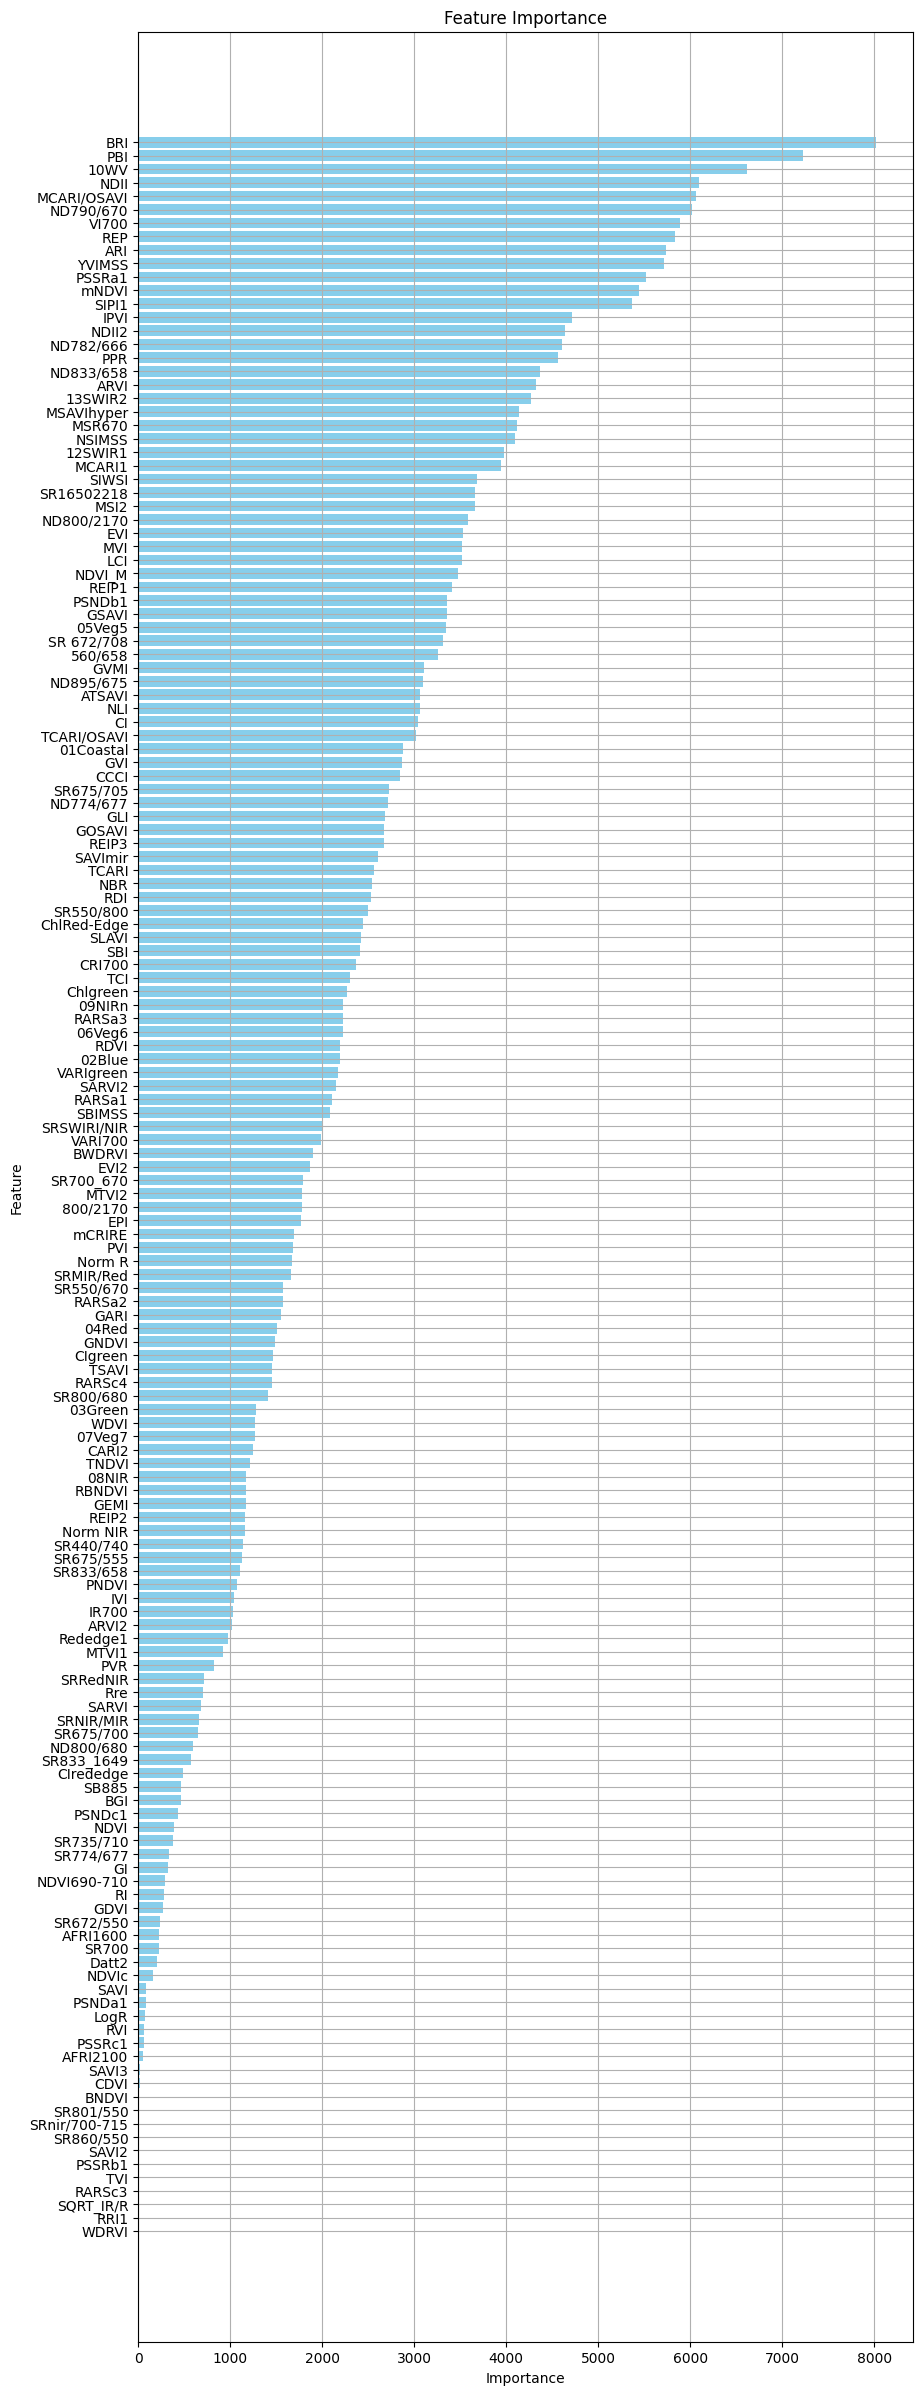

In [41]:
# Sorting the dataframe by Importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the graph
plt.figure(figsize=(10, 30))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

In [50]:
IMr6000 = feature_importance_df[feature_importance_df['Importance']>=6000]
IMr6000 = IMr6000['Feature'].tolist()
IMr6000

['BRI', 'PBI', '10WV', 'NDII', 'MCARI/OSAVI', 'ND790/670']

In [52]:
IMr5000 = feature_importance_df[feature_importance_df['Importance']>=5000]
IMr5000 = IMr5000['Feature'].tolist()
IMr5000

['BRI',
 'PBI',
 '10WV',
 'NDII',
 'MCARI/OSAVI',
 'ND790/670',
 'VI700',
 'REP',
 'ARI',
 'YVIMSS',
 'PSSRa1',
 'mNDVI',
 'SIPI1']

In [53]:
IMr4000 = feature_importance_df[feature_importance_df['Importance']>=4000]
IMr4000 = IMr4000['Feature'].tolist()
IMr4000

['BRI',
 'PBI',
 '10WV',
 'NDII',
 'MCARI/OSAVI',
 'ND790/670',
 'VI700',
 'REP',
 'ARI',
 'YVIMSS',
 'PSSRa1',
 'mNDVI',
 'SIPI1',
 'IPVI',
 'NDII2',
 'ND782/666',
 'PPR',
 'ND833/658',
 'ARVI',
 '13SWIR2',
 'MSAVIhyper',
 'MSR670',
 'NSIMSS']

In [54]:
IMr3000 = feature_importance_df[feature_importance_df['Importance']>=3000]
IMr3000 = IMr3000['Feature'].tolist()
IMr3000

['BRI',
 'PBI',
 '10WV',
 'NDII',
 'MCARI/OSAVI',
 'ND790/670',
 'VI700',
 'REP',
 'ARI',
 'YVIMSS',
 'PSSRa1',
 'mNDVI',
 'SIPI1',
 'IPVI',
 'NDII2',
 'ND782/666',
 'PPR',
 'ND833/658',
 'ARVI',
 '13SWIR2',
 'MSAVIhyper',
 'MSR670',
 'NSIMSS',
 '12SWIR1',
 'MCARI1',
 'SIWSI',
 'SR16502218',
 'MSI2',
 'ND800/2170',
 'EVI',
 'MVI',
 'LCI',
 'NDVI_M',
 'REIP1',
 'PSNDb1',
 'GSAVI',
 '05Veg5',
 'SR 672/708',
 '560/658',
 'GVMI',
 'ND895/675',
 'ATSAVI',
 'NLI',
 'CI',
 'TCARI/OSAVI']

In [55]:
IMr2000 = feature_importance_df[feature_importance_df['Importance']>=2000]
IMr2000 = IMr2000['Feature'].tolist()
IMr2000

['BRI',
 'PBI',
 '10WV',
 'NDII',
 'MCARI/OSAVI',
 'ND790/670',
 'VI700',
 'REP',
 'ARI',
 'YVIMSS',
 'PSSRa1',
 'mNDVI',
 'SIPI1',
 'IPVI',
 'NDII2',
 'ND782/666',
 'PPR',
 'ND833/658',
 'ARVI',
 '13SWIR2',
 'MSAVIhyper',
 'MSR670',
 'NSIMSS',
 '12SWIR1',
 'MCARI1',
 'SIWSI',
 'SR16502218',
 'MSI2',
 'ND800/2170',
 'EVI',
 'MVI',
 'LCI',
 'NDVI_M',
 'REIP1',
 'PSNDb1',
 'GSAVI',
 '05Veg5',
 'SR 672/708',
 '560/658',
 'GVMI',
 'ND895/675',
 'ATSAVI',
 'NLI',
 'CI',
 'TCARI/OSAVI',
 '01Coastal',
 'GVI',
 'CCCI',
 'SR675/705',
 'ND774/677',
 'GLI',
 'GOSAVI',
 'REIP3',
 'SAVImir',
 'TCARI',
 'NBR',
 'RDI',
 'SR550/800',
 'ChlRed-Edge',
 'SLAVI',
 'SBI',
 'CRI700',
 'TCI',
 'Chlgreen',
 '09NIRn',
 'RARSa3',
 '06Veg6',
 'RDVI',
 '02Blue',
 'VARIgreen',
 'SARVI2',
 'RARSa1',
 'SBIMSS',
 'SRSWIRI/NIR']

In [56]:
IMr1000 = feature_importance_df[feature_importance_df['Importance']>=1000]
IMr1000 = IMr1000['Feature'].tolist()
IMr1000

['BRI',
 'PBI',
 '10WV',
 'NDII',
 'MCARI/OSAVI',
 'ND790/670',
 'VI700',
 'REP',
 'ARI',
 'YVIMSS',
 'PSSRa1',
 'mNDVI',
 'SIPI1',
 'IPVI',
 'NDII2',
 'ND782/666',
 'PPR',
 'ND833/658',
 'ARVI',
 '13SWIR2',
 'MSAVIhyper',
 'MSR670',
 'NSIMSS',
 '12SWIR1',
 'MCARI1',
 'SIWSI',
 'SR16502218',
 'MSI2',
 'ND800/2170',
 'EVI',
 'MVI',
 'LCI',
 'NDVI_M',
 'REIP1',
 'PSNDb1',
 'GSAVI',
 '05Veg5',
 'SR 672/708',
 '560/658',
 'GVMI',
 'ND895/675',
 'ATSAVI',
 'NLI',
 'CI',
 'TCARI/OSAVI',
 '01Coastal',
 'GVI',
 'CCCI',
 'SR675/705',
 'ND774/677',
 'GLI',
 'GOSAVI',
 'REIP3',
 'SAVImir',
 'TCARI',
 'NBR',
 'RDI',
 'SR550/800',
 'ChlRed-Edge',
 'SLAVI',
 'SBI',
 'CRI700',
 'TCI',
 'Chlgreen',
 '09NIRn',
 'RARSa3',
 '06Veg6',
 'RDVI',
 '02Blue',
 'VARIgreen',
 'SARVI2',
 'RARSa1',
 'SBIMSS',
 'SRSWIRI/NIR',
 'VARI700',
 'BWDRVI',
 'EVI2',
 'SR700_670',
 'MTVI2',
 '800/2170',
 'EPI',
 'mCRIRE',
 'PVI',
 'Norm R',
 'SRMIR/Red',
 'SR550/670',
 'RARSa2',
 'GARI',
 '04Red',
 'GNDVI',
 'CIgreen',
 'TSA

In [57]:
IMr500 = feature_importance_df[feature_importance_df['Importance']>=500]
IMr500 = IMr500['Feature'].tolist()
IMr500

['BRI',
 'PBI',
 '10WV',
 'NDII',
 'MCARI/OSAVI',
 'ND790/670',
 'VI700',
 'REP',
 'ARI',
 'YVIMSS',
 'PSSRa1',
 'mNDVI',
 'SIPI1',
 'IPVI',
 'NDII2',
 'ND782/666',
 'PPR',
 'ND833/658',
 'ARVI',
 '13SWIR2',
 'MSAVIhyper',
 'MSR670',
 'NSIMSS',
 '12SWIR1',
 'MCARI1',
 'SIWSI',
 'SR16502218',
 'MSI2',
 'ND800/2170',
 'EVI',
 'MVI',
 'LCI',
 'NDVI_M',
 'REIP1',
 'PSNDb1',
 'GSAVI',
 '05Veg5',
 'SR 672/708',
 '560/658',
 'GVMI',
 'ND895/675',
 'ATSAVI',
 'NLI',
 'CI',
 'TCARI/OSAVI',
 '01Coastal',
 'GVI',
 'CCCI',
 'SR675/705',
 'ND774/677',
 'GLI',
 'GOSAVI',
 'REIP3',
 'SAVImir',
 'TCARI',
 'NBR',
 'RDI',
 'SR550/800',
 'ChlRed-Edge',
 'SLAVI',
 'SBI',
 'CRI700',
 'TCI',
 'Chlgreen',
 '09NIRn',
 'RARSa3',
 '06Veg6',
 'RDVI',
 '02Blue',
 'VARIgreen',
 'SARVI2',
 'RARSa1',
 'SBIMSS',
 'SRSWIRI/NIR',
 'VARI700',
 'BWDRVI',
 'EVI2',
 'SR700_670',
 'MTVI2',
 '800/2170',
 'EPI',
 'mCRIRE',
 'PVI',
 'Norm R',
 'SRMIR/Red',
 'SR550/670',
 'RARSa2',
 'GARI',
 '04Red',
 'GNDVI',
 'CIgreen',
 'TSA

In [31]:
final_clf.predict(X_test[X_test['id'] == 13467].drop(columns=['id']))

[LightGBM] [Warning] feature_fraction is set=0.7882010344956594, colsample_bytree=0.7135692755606239 will be ignored. Current value: feature_fraction=0.7882010344956594
[LightGBM] [Warning] lambda_l2 is set=0.30126871090151336, reg_lambda=1.629457326507753e-05 will be ignored. Current value: lambda_l2=0.30126871090151336
[LightGBM] [Warning] lambda_l1 is set=0.0002572974420115495, reg_alpha=0.06728674046587282 will be ignored. Current value: lambda_l1=0.0002572974420115495
[LightGBM] [Warning] bagging_fraction is set=0.7648626929860491, subsample=0.6125112452508354 will be ignored. Current value: bagging_fraction=0.7648626929860491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


array(['DEF'], dtype=object)

In [32]:
df = pd.read_csv("/content/sample_submission.csv")
for idx,row in df.iterrows():
#     print(X_test[X_test['id'] == row['id']])
    data = X_test[X_test['id'] == row['id']].drop(columns=['id'])      # เปิดข้อมูลรายตัวตาม id ของ sample_submission.csv file
    result = final_clf.predict(data)
    df.at[idx,'nforest_type'] = result
#     break

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] feature_fraction is set=0.7882010344956594, colsample_bytree=0.7135692755606239 will be ignored. Current value: feature_fraction=0.7882010344956594
[LightGBM] [Warning] lambda_l2 is set=0.30126871090151336, reg_lambda=1.629457326507753e-05 will be ignored. Current value: lambda_l2=0.30126871090151336
[LightGBM] [Warning] lambda_l1 is set=0.0002572974420115495, reg_alpha=0.06728674046587282 will be ignored. Current value: lambda_l1=0.0002572974420115495
[LightGBM] [Warning] bagging_fraction is set=0.7648626929860491, subsample=0.6125112452508354 will be ignored. Current value: bagging_fraction=0.7648626929860491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7882010344956594, colsample_bytree=0.7135692755606239 will be ignored. Current value: feature_fraction=0.7882010344956594
[LightGBM] [Warning] lambda_l2 i

In [33]:
df

,id,nforest_type
0,13467,DEF
1,12719,MDF
2,1054,MDF
3,13747,DDF
4,9453,DDF
...,...,...
3995,115,MDF
3996,10654,MDF
3997,5718,DDF
3998,13054,MDF


In [34]:
version = '0.4.0'
formatted_time = time.strftime("%H.%M", time.localtime())
formatted_time = str(int(formatted_time.split(".")[0])+7)+formatted_time.split(".")[1]
formatted_time
csv_name = f'v.{version}.{formatted_time}.csv'
print(csv_name)
df.to_csv(csv_name,index=False)

v.0.4.0.2858.csv
